# **EMEM 539** Final Project - "Prediction of default of credit card clients" 
## Yerzhan Mukhanov, Adil Kaskyrbayev  
The main objective of our project is to predict, will the client be able to pay the credit or there is a risk in default.

In [5]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt                          # plotting
import seaborn as sns                                    # similar to matplotlib
from imblearn.under_sampling import RandomUnderSampler   # to balance target value 
from sklearn.preprocessing import StandardScaler         # standart deviation scaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report

print("First, lets find the path to the dataset:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


First, lets find the path to the dataset:
/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv


Now, lets analyse the dataset by loading it to dataframe:

In [6]:
df = pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv', delimiter=',')
df.dataframeName = 'UCI_Credit_Card.csv'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

Here we can see, that there is no PAY_1 column, however the dataset documentations says:   
"**PAY_0**: Repayment status in September, 2005 
 **PAY_2**: Repayment status in August, 2005"
 Thus, we can rename column to avoid confuse  
 Also we can delete column ID, because it doent have an impact on our prediction:

In [7]:
df.rename(columns={'PAY_0':'PAY_1'}, inplace=True)
df.drop("ID",axis=1,inplace=True)
df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Also, the values in columns PAY_i are not clear described in Kaggle, but there is a discussion under the dataset page, where the creator answered question about meaning of the columns [(link)](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608) :  
  
"-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above."  

  
Next, lets check, if there are NULL values in dataset, so that the further analysis will show proper results:

In [8]:
df.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

By trying to visualise metrics, we faced issues using column " default.payment.next.month " thus lets rename it to "DPNM"

In [9]:
df.rename(columns={'default.payment.next.month':'DPNM'}, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DPNM
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Correlation Matrix

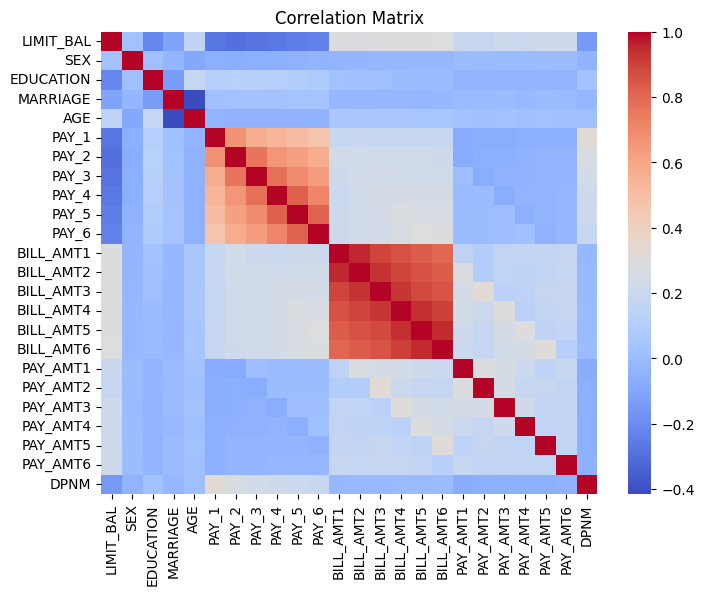

In [10]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


## Lets **normalize** some features:

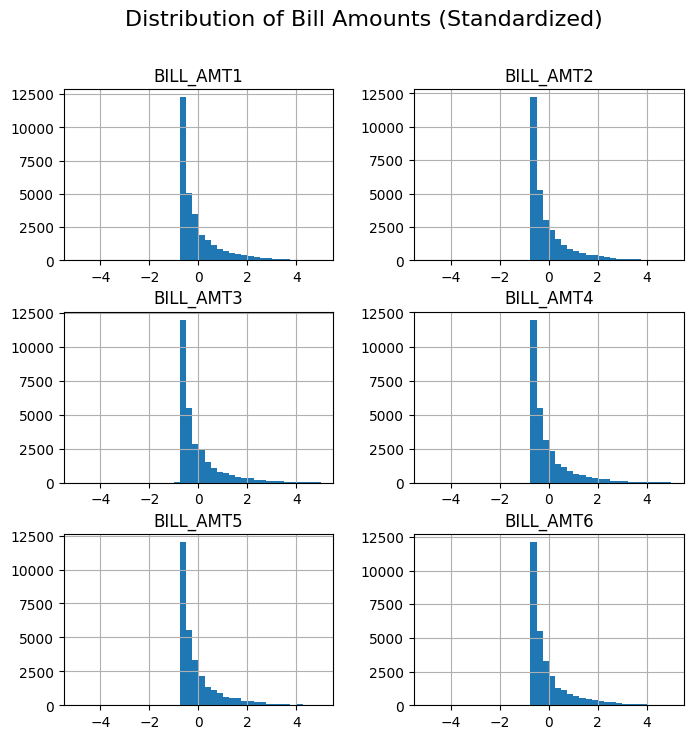

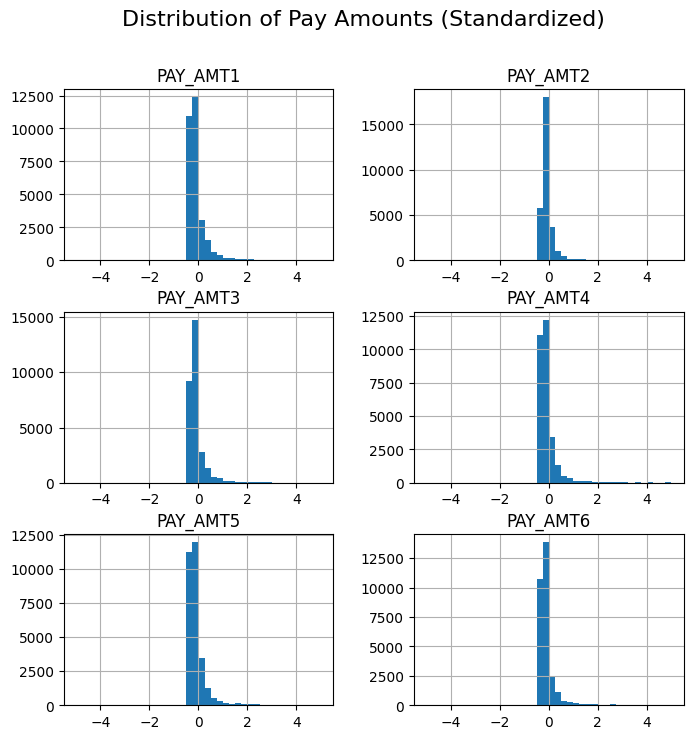

In [11]:
scaler = StandardScaler()

# List of columns related to Bill Amount and Pay Amount
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Apply Standardization (Z-score normalization) to Bill Amount and Pay Amount columns
df[bill_columns] = scaler.fit_transform(df[bill_columns])
df[pay_columns] = scaler.fit_transform(df[pay_columns])

# Standardize Limit Balance
df['LIMIT_BAL'] = scaler.fit_transform(df[['LIMIT_BAL']])

# Visualize distributions after standardization (optional)
df[bill_columns].hist(figsize=(8, 8), bins=40, range=(-5, 5))
plt.suptitle('Distribution of Bill Amounts (Standardized)', fontsize=16)
plt.show()

df[pay_columns].hist(figsize=(8, 8), bins=40, range=(-5, 5))
plt.suptitle('Distribution of Pay Amounts (Standardized)', fontsize=16)
plt.show()

## Lets plot default payment next month, to see what is the probability of default based on dataset.  
## And for better understanding, we chose to change 0 to 1 and 1 to 0. 

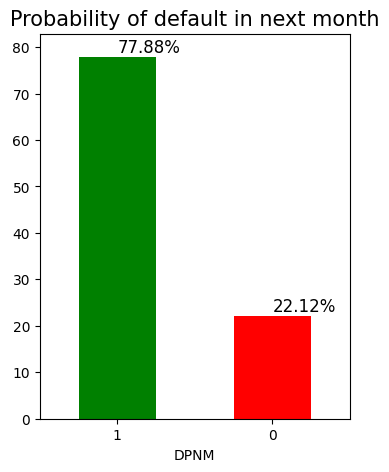

In [12]:
df['DPNM'] = df['DPNM'].replace({0: 1, 1: 0})
def_cnt = (df.DPNM.value_counts(normalize=True)*100) 
def_cnt.plot.bar(figsize=(4,5), color=['green', 'red'])
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.title("Probability of default in next month", fontsize=15)
plt.ylim(0, def_cnt.max() + 5)                                         # broading upper limit
for x,y in zip([0,1],def_cnt):
    plt.text(x,y + 1, f'{y:.2f}%',fontsize=12)                         # pretty text formating
plt.show()

As it is observed, almost 22% clients are likely to default, wheares 77% are not.  
So we would like to reduce balance our target value:

Class distribution before under-sampling: Counter({1: 23364, 0: 6636})
Class distribution after under-sampling: Counter({1: 22120, 0: 6636})


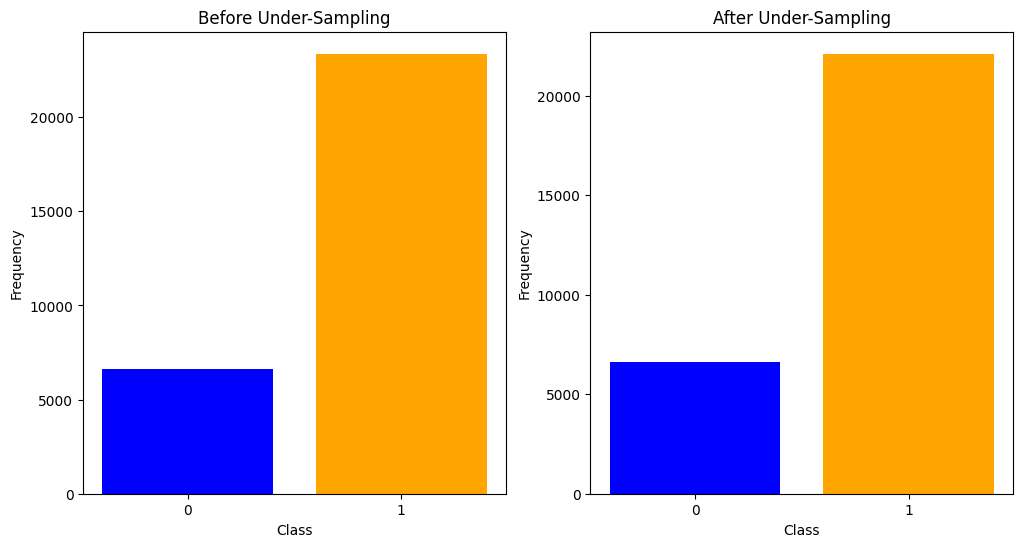

In [14]:

from collections import Counter
# Inspect the target column
target_column = 'DPNM'
print("Class distribution before under-sampling:", Counter(df[target_column]))

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Apply under-sampling
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # 70% of minority class

X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Inspect the resampled target distribution
print("Class distribution after under-sampling:", Counter(y_resampled))

# Plot class distribution before and after under-sampling
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Before under-sampling
ax[0].bar(Counter(y).keys(), Counter(y).values(), color=['blue', 'orange'])
ax[0].set_title("Before Under-Sampling")
ax[0].set_xlabel("Class")
ax[0].set_xticks([0, 1])
ax[0].set_ylabel("Frequency")

# After under-sampling
ax[1].bar(Counter(y_resampled).keys(), Counter(y_resampled).values(), color=['blue', 'orange'])
ax[1].set_title("After Under-Sampling")
ax[1].set_xlabel("Class")
ax[1].set_xticks([0, 1])
ax[1].set_ylabel("Frequency")

plt.show()

Put everything together in one dataframe

In [12]:
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)  # Resampled features
df_resampled['DPNM'] = y_resampled  # Add the resampled target column
df_resampled = df_resampled.reset_index(drop=True)
df_resampled.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DPNM
0,-1.136720,2,2,1,24,2,2,-1,-1,-2,...,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,0
1,-0.365981,2,2,2,26,-1,2,0,0,0,...,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,0
2,-0.751350,1,2,2,30,1,2,2,0,0,...,0.365590,-0.068662,-0.033210,-0.148740,-0.256990,-0.126411,-0.116564,-0.215956,-0.293382,0
3,-1.136720,1,1,2,24,0,0,2,2,2,...,-0.387444,-0.368550,-0.331935,-0.148740,-0.256990,-0.211606,-0.308063,-0.206138,-0.293382,0
4,-0.365981,2,2,1,39,-1,-1,-1,-1,-1,...,-0.672497,-0.652663,-0.647418,-0.322863,-0.243275,-0.296801,-0.267720,-0.293453,-0.293382,0


Now we can find which columns impacts the further model and which does not.
Lets start with Marriage:
(1 = married; 2 = single; 3 = divorce; 0=others).


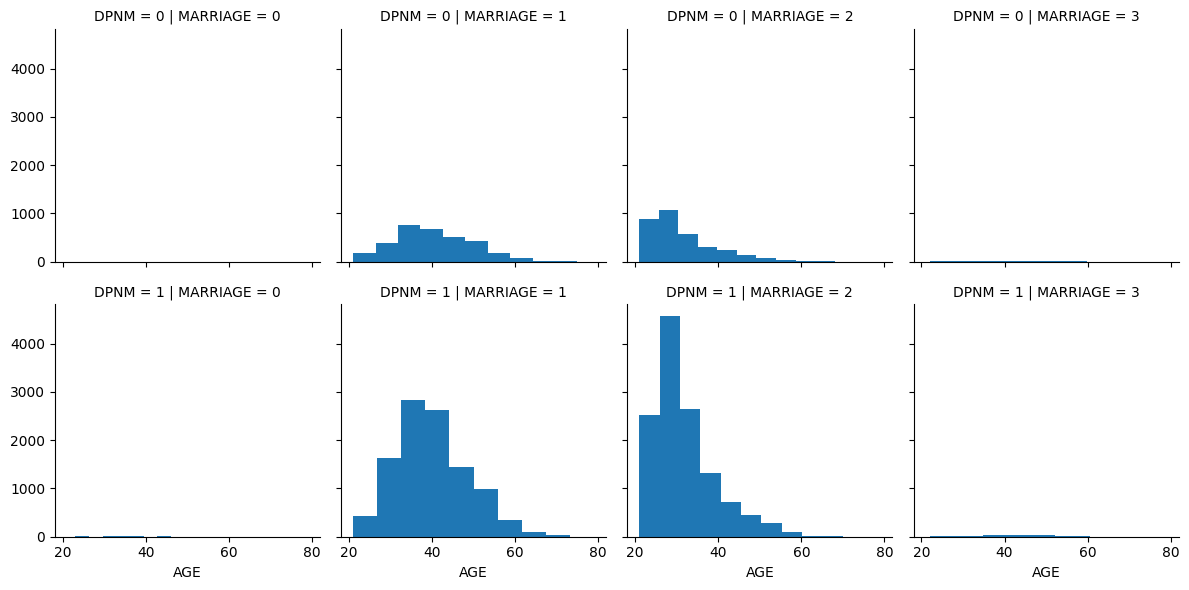

In [13]:
g = sns.FacetGrid(df, row='DPNM', col='MARRIAGE')
g = g.map(plt.hist, 'AGE')
plt.show()

As it is illustrated we can say that married people aged from 30 to 50 and unmarried clients of age 20-30 tend to default payment.   
Unmarried clients higher probability to default payment.   
So we can include MARRIAGE to find probability of defaulting the payment next month

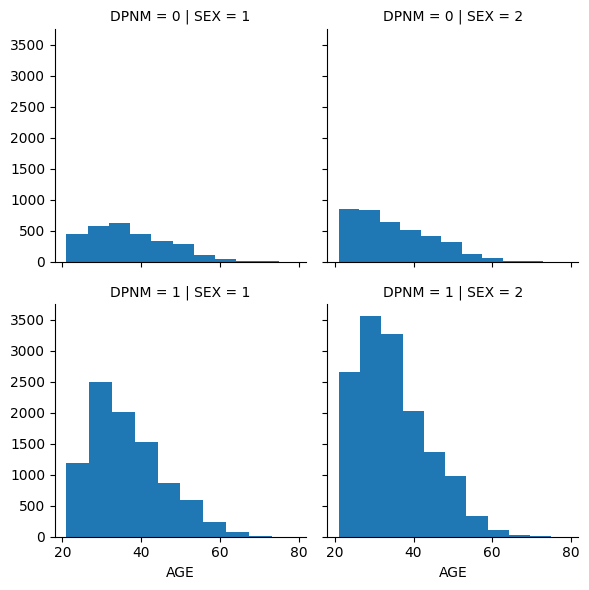

In [14]:
g = sns.FacetGrid(df, row='DPNM', col='SEX')
g = g.map(plt.hist, 'AGE')

Now if we consider SEX, it can be seen that females of age group 20-30 have very high tendency to default payment compared to males in all age brackets. Eventually we use the SEX column.

## Now lets create test and train data

# KNN [compared to link](https://www.kaggle.com/code/ffy208/credit-card-default-prediction)


In [15]:
X = df_resampled.drop(columns=['DPNM'])  # Features
y = df_resampled['DPNM']  # Target variable
# X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7],  # Try different values of K
    'weights': ['uniform', 'distance'],  # Different ways to weight the neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Different distance metrics
}

# Instantiate the KNN model
knn = KNeighborsClassifier()

# Apply GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Use the best model found by GridSearchCV
best_knn = grid_search.best_estimator_

# Train the best model on the full training set
best_knn.fit(X_train, y_train)

# Make predictions
y_pred = best_knn.predict(X_test)

# Compute the metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Optionally, print a classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy: 0.7926
ROC AUC: 0.6364
Precision: 0.8304
Recall: 0.9204
F1-Score: 0.8731

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.35      0.43      1294
           1       0.83      0.92      0.87      4458

    accuracy                           0.79      5752
   macro avg       0.70      0.64      0.65      5752
weighted avg       0.77      0.79      0.77      5752



# LogisticRegression

In [16]:
X = df_resampled.drop(columns=['DPNM'])  # Features
y = df_resampled['DPNM']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8067
ROC AUC: 0.7231
Precision: 0.8139
Recall: 0.9706
F1-Score: 0.8854

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.26      0.38      1327
           1       0.81      0.97      0.89      4425

    accuracy                           0.81      5752
   macro avg       0.77      0.62      0.63      5752
weighted avg       0.79      0.81      0.77      5752



## Random Forest

In [17]:
X = df_resampled.drop(columns=['DPNM'])  # Features
y = df_resampled['DPNM']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]  # For ROC AUC

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8103
ROC AUC: 0.7650
Precision: 0.8364
Recall: 0.9367
F1-Score: 0.8837

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.39      0.49      1327
           1       0.84      0.94      0.88      4425

    accuracy                           0.81      5752
   macro avg       0.74      0.66      0.68      5752
weighted avg       0.79      0.81      0.79      5752



## SVC

In [20]:
X = df_resampled.drop(columns=['DPNM'])  # Features
y = df_resampled['DPNM']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the SVC model
svc_model = SVC(kernel='rbf', random_state=42)  # You can adjust the kernel as needed
svc_model.fit(X_train, y_train)

y_scores = svc_model.decision_function(X_test)

accuracy = accuracy_score(y_test, svc_model.predict(X_test))
roc_auc = roc_auc_score(y_test, y_scores)
precision = precision_score(y_test, svc_model.predict(X_test))
recall = recall_score(y_test, svc_model.predict(X_test))
f1 = f1_score(y_test, svc_model.predict(X_test))

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7916
ROC AUC: 0.6303
Precision: 0.7937
Recall: 0.9851
F1-Score: 0.8791

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.15      0.24      1327
           1       0.79      0.99      0.88      4425

    accuracy                           0.79      5752
   macro avg       0.77      0.57      0.56      5752
weighted avg       0.78      0.79      0.73      5752



# Decision tree

In [18]:
X = df_resampled.drop(columns=['DPNM'])  # Features
y = df_resampled['DPNM']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=None, criterion='gini')  # Adjust hyperparameters as needed
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)
y_prob = dt_model.predict_proba(X_test)[:, 1]  # For ROC AUC

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7314
ROC AUC: 0.6303
Precision: 0.8303
Recall: 0.8181
F1-Score: 0.8241

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.44      0.43      1327
           1       0.83      0.82      0.82      4425

    accuracy                           0.73      5752
   macro avg       0.63      0.63      0.63      5752
weighted avg       0.74      0.73      0.73      5752

